In [3]:
!mkdir /content/drive/MyDrive/mask_dataset

In [5]:
%cp "/content/drive/MyDrive/Soumaya - PFE/files/labels_my-project-name_2021-09-13-11-22-40.json" "/content"

In [8]:
%cp "/content/drive/MyDrive/Soumaya - PFE/Models code/Mask R-CNN/dataset.zip" "/content"

In [9]:
%tensorflow_version 1.x
!pip install --upgrade h5py==2.10.0
!git clone https://github.com/pysource7/Mask_RCNN
import sys
sys.path.append("/content/Mask_RCNN/demo")
from train_mask_rcnn_demo import *
%matplotlib inline

TensorFlow 1.x selected.
     |████████████████████████████████| 2.9 MB 11.1 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 1047, done.
remote: Total 1047 (delta 0), reused 0 (delta 0), pack-reused 1047
Receiving objects: 100% (1047/1047), 125.29 MiB | 22.99 MiB/s, done.
Resolving deltas: 100% (615/615), done.
VERS 0.2


Using TensorFlow backend.


... done downloading pretrained model!


In [ ]:
class CustomDataset1(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """

    def load_custom(self, annotation_json, images_dir, dataset_type="train"):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """

        # Load json from file
        print("Annotation json path: ", annotation_json)
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()


        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']

            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(
                    class_name))
                return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}

        # Split the dataset, if train, get 90%, else 10%
        len_images = len(coco_json['images'])
        if dataset_type == "train":
            img_range = [int(len_images / 9), len_images]
        elif dataset_type == "whole_ds":
          img_range = [0, len_images]

        else:
            img_range = [0, int(len_images / 9)]

        for i in range(img_range[0], img_range[1]):
            image = coco_json['images'][i]
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]

                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        #print("Class_ids, ", class_ids)
        return mask, class_ids

    def count_classes(self):
        class_ids = set()
        for image_id in self.image_ids:
            image_info = self.image_info[image_id]
            annotations = image_info['annotations']

            for annotation in annotations:
                class_id = annotation['category_id']
                class_ids.add(class_id)

        class_number = len(class_ids)
        return class_number


In [ ]:
def load_image_dataset1(annotation_path, dataset_path, dataset_type):
    dataset_train = CustomDataset1()
    dataset_train.load_custom(annotation_path, dataset_path, dataset_type)
    dataset_train.prepare()
    return dataset_train

Image dataset

In [10]:
images_path = "/content/dataset.zip"
annotations_path= "/content/labels_my-project-name_2021-09-13-11-22-40.json"
extract_images(os.path.join("/content/",images_path), "/content/dataset")

Extracted: 3000 images


In [11]:
dataset_train = load_image_dataset(os.path.join("/content/", annotations_path),"/content/dataset","train")
dataset_val = load_image_dataset(os.path.join("/content/",annotations_path),"/content/dataset", "validation")
print('validation : %d' % len(dataset_val.image_ids))

class_number = dataset_train.count_classes()
print("Classes: {}".format(class_number))

Annotation json path:  /content/labels_my-project-name_2021-09-13-11-22-40.json
Annotation json path:  /content/labels_my-project-name_2021-09-13-11-22-40.json
validation : 333
Classes: 2


In [ ]:
whole_ds = load_image_dataset1(os.path.join("/content/", annotations_path),"/content/dataset","whole_ds")

Annotation json path:  /content/annotations.json


In [ ]:
print(len(whole_ds.image_ids))

3000


In [12]:
from train_mask_rcnn_demo import *

In [13]:
from train_mask_rcnn_pro import *

VERS 0.2


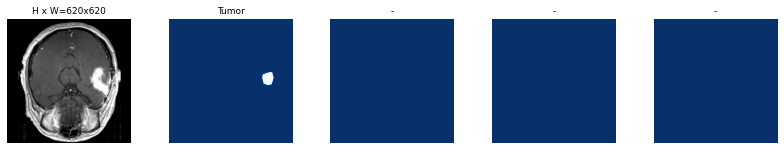

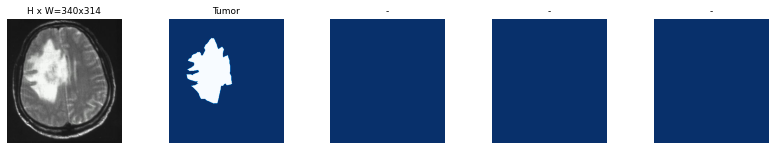

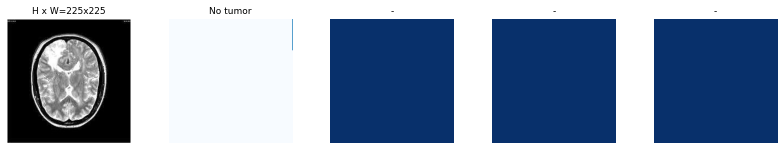

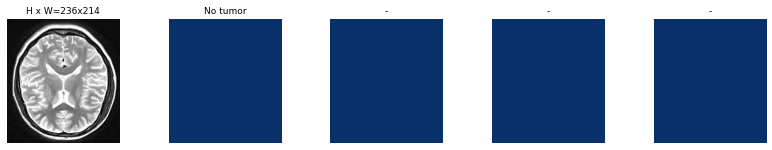

In [14]:
display_image_samples(dataset_train)

In [ ]:
from PIL import Image
import numpy as np

In [ ]:
# image_ids = np.random.choice(dataset_train.image_ids, 4)
# i=1
# for image_id in image_ids:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     img = Image.fromarray(mask, 'RGB')
#     mask_name="mask"+str(i)
#     mask_path='/content/masks_dataset/'+mask_name
#     img.save(mask_path)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

Training

In [15]:
config = CustomConfig(class_number)
# config.display()
model= load_training_model(config,"/content/brainTumor")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
/content/Mask_RCNN/mask_rcnn_coco.h5


In [16]:
#start training
train_head(model, dataset_train, dataset_train,config,5)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/brainTumor/object20210930T0116/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

Detection (test your model on a random image)

In [17]:
#Load Test Model
test_model, inference_config = load_test_model(class_number,'/content/brainTumor')



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/brainTumor/object20210930T0116/mask_rcnn_object_0005.h5
Re-starting from epoch 5


In [1]:
#Test on a random image
test_random_image(test_model, dataset_val, inference_config)

NameError: ignored

In [ ]:
from PIL import Image as im

In [ ]:
"""
Mask R-CNN
Common utility functions and classes.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import sys
import os
import logging
import math
import random
import numpy as np
import tensorflow as tf
import scipy
import skimage.color
import skimage.io
import skimage.transform
import urllib.request
import shutil
import warnings
from distutils.version import LooseVersion

# URL from which to download the latest COCO trained weights
COCO_MODEL_URL = "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"


############################################################
#  Bounding Boxes
############################################################

def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.

    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)


def compute_iou(box, boxes, box_area, boxes_area):
    """Calculates IoU of the given box with the array of the given boxes.
    box: 1D vector [y1, x1, y2, x2]
    boxes: [boxes_count, (y1, x1, y2, x2)]
    box_area: float. the area of 'box'
    boxes_area: array of length boxes_count.

    Note: the areas are passed in rather than calculated here for
    efficiency. Calculate once in the caller to avoid duplicate work.
    """
    # Calculate intersection areas
    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou


def compute_overlaps(boxes1, boxes2):
    """Computes IoU overlaps between two sets of boxes.
    boxes1, boxes2: [N, (y1, x1, y2, x2)].

    For better performance, pass the largest set first and the smaller second.
    """
    # Areas of anchors and GT boxes
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # Compute overlaps to generate matrix [boxes1 count, boxes2 count]
    # Each cell contains the IoU value.
    overlaps = np.zeros((boxes1.shape[0], boxes2.shape[0]))
    for i in range(overlaps.shape[1]):
        box2 = boxes2[i]
        overlaps[:, i] = compute_iou(box2, boxes1, area2[i], area1)
    return overlaps


def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """
    
    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union

    return overlaps


def non_max_suppression(boxes, scores, threshold):
    """Performs non-maximum suppression and returns indices of kept boxes.
    boxes: [N, (y1, x1, y2, x2)]. Notice that (y2, x2) lays outside the box.
    scores: 1-D array of box scores.
    threshold: Float. IoU threshold to use for filtering.
    """
    assert boxes.shape[0] > 0
    if boxes.dtype.kind != "f":
        boxes = boxes.astype(np.float32)

    # Compute box areas
    y1 = boxes[:, 0]
    x1 = boxes[:, 1]
    y2 = boxes[:, 2]
    x2 = boxes[:, 3]
    area = (y2 - y1) * (x2 - x1)

    # Get indicies of boxes sorted by scores (highest first)
    ixs = scores.argsort()[::-1]

    pick = []
    while len(ixs) > 0:
        # Pick top box and add its index to the list
        i = ixs[0]
        pick.append(i)
        # Compute IoU of the picked box with the rest
        iou = compute_iou(boxes[i], boxes[ixs[1:]], area[i], area[ixs[1:]])
        # Identify boxes with IoU over the threshold. This
        # returns indices into ixs[1:], so add 1 to get
        # indices into ixs.
        remove_ixs = np.where(iou > threshold)[0] + 1
        # Remove indices of the picked and overlapped boxes.
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)
    return np.array(pick, dtype=np.int32)


def apply_box_deltas(boxes, deltas):
    """Applies the given deltas to the given boxes.
    boxes: [N, (y1, x1, y2, x2)]. Note that (y2, x2) is outside the box.
    deltas: [N, (dy, dx, log(dh), log(dw))]
    """
    boxes = boxes.astype(np.float32)
    # Convert to y, x, h, w
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height *= np.exp(deltas[:, 2])
    width *= np.exp(deltas[:, 3])
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    return np.stack([y1, x1, y2, x2], axis=1)


def box_refinement_graph(box, gt_box):
    """Compute refinement needed to transform box to gt_box.
    box and gt_box are [N, (y1, x1, y2, x2)]
    """
    box = tf.cast(box, tf.float32)
    gt_box = tf.cast(gt_box, tf.float32)

    height = box[:, 2] - box[:, 0]
    width = box[:, 3] - box[:, 1]
    center_y = box[:, 0] + 0.5 * height
    center_x = box[:, 1] + 0.5 * width

    gt_height = gt_box[:, 2] - gt_box[:, 0]
    gt_width = gt_box[:, 3] - gt_box[:, 1]
    gt_center_y = gt_box[:, 0] + 0.5 * gt_height
    gt_center_x = gt_box[:, 1] + 0.5 * gt_width

    dy = (gt_center_y - center_y) / height
    dx = (gt_center_x - center_x) / width
    dh = tf.log(gt_height / height)
    dw = tf.log(gt_width / width)

    result = tf.stack([dy, dx, dh, dw], axis=1)
    return result


def box_refinement(box, gt_box):
    """Compute refinement needed to transform box to gt_box.
    box and gt_box are [N, (y1, x1, y2, x2)]. (y2, x2) is
    assumed to be outside the box.
    """
    box = box.astype(np.float32)
    gt_box = gt_box.astype(np.float32)

    height = box[:, 2] - box[:, 0]
    width = box[:, 3] - box[:, 1]
    center_y = box[:, 0] + 0.5 * height
    center_x = box[:, 1] + 0.5 * width

    gt_height = gt_box[:, 2] - gt_box[:, 0]
    gt_width = gt_box[:, 3] - gt_box[:, 1]
    gt_center_y = gt_box[:, 0] + 0.5 * gt_height
    gt_center_x = gt_box[:, 1] + 0.5 * gt_width

    dy = (gt_center_y - center_y) / height
    dx = (gt_center_x - center_x) / width
    dh = np.log(gt_height / height)
    dw = np.log(gt_width / width)

    return np.stack([dy, dx, dh, dw], axis=1)


############################################################
#  Dataset
############################################################

class Dataset(object):
    """The base class for dataset classes.
    To use it, create a new class that adds functions specific to the dataset
    you want to use. For example:

    class CatsAndDogsDataset(Dataset):
        def load_cats_and_dogs(self):
            ...
        def load_mask(self, image_id):
            ...
        def image_reference(self, image_id):
            ...

    See COCODataset and ShapesDataset as examples.
    """

    def __init__(self, class_map=None):
        self._image_ids = []
        self.image_info = []
        # Background is always the first class
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]
        self.source_class_ids = {}

    def add_class(self, source, class_id, class_name):
        assert "." not in source, "Source name cannot contain a dot"
        # Does the class exist already?
        for info in self.class_info:
            if info['source'] == source and info["id"] == class_id:
                # source.class_id combination already available, skip
                return
        # Add the class
        self.class_info.append({
            "source": source,
            "id": class_id,
            "name": class_name,
        })

    def add_image(self, source, image_id, path, **kwargs):
        image_info = {
            "id": image_id,
            "source": source,
            "path": path,
        }
        image_info.update(kwargs)
        self.image_info.append(image_info)

    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about
        the image that help looking it up or debugging it.

        Override for your dataset, but pass to this function
        if you encounter images not in your dataset.
        """
        return ""

    def prepare(self, class_map=None):
        """Prepares the Dataset class for use.

        TODO: class map is not supported yet. When done, it should handle mapping
              classes from different datasets to the same class ID.
        """

        def clean_name(name):
            """Returns a shorter version of object names for cleaner display."""
            return ",".join(name.split(",")[:1])

        # Build (or rebuild) everything else from the info dicts.
        self.num_classes = len(self.class_info)
        self.class_ids = np.arange(self.num_classes)
        self.class_names = [clean_name(c["name"]) for c in self.class_info]
        self.num_images = len(self.image_info)
        self._image_ids = np.arange(self.num_images)

        # Mapping from source class and image IDs to internal IDs
        self.class_from_source_map = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.class_info, self.class_ids)}
        self.image_from_source_map = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.image_info, self.image_ids)}

        # Map sources to class_ids they support
        self.sources = list(set([i['source'] for i in self.class_info]))
        self.source_class_ids = {}
        # Loop over datasets
        for source in self.sources:
            self.source_class_ids[source] = []
            # Find classes that belong to this dataset
            for i, info in enumerate(self.class_info):
                # Include BG class in all datasets
                if i == 0 or source == info['source']:
                    self.source_class_ids[source].append(i)

    def map_source_class_id(self, source_class_id):
        """Takes a source class ID and returns the int class ID assigned to it.

        For example:
        dataset.map_source_class_id("coco.12") -> 23
        """
        return self.class_from_source_map[source_class_id]

    def get_source_class_id(self, class_id, source):
        """Map an internal class ID to the corresponding class ID in the source dataset."""
        info = self.class_info[class_id]
        assert info['source'] == source
        return info['id']

    @property
    def image_ids(self):
        return self._image_ids

    def source_image_link(self, image_id):
        """Returns the path or URL to the image.
        Override this to return a URL to the image if it's available online for easy
        debugging.
        """
        return self.image_info[image_id]["path"]

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. Override this
        method to load instance masks and return them in the form of am
        array of binary masks of shape [height, width, instances].

        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        # Override this function to load a mask from your dataset.
        # Otherwise, it returns an empty mask.
        logging.warning("You are using the default load_mask(), maybe you need to define your own one.")
        mask = np.empty([0, 0, 0])
        class_ids = np.empty([0], np.int32)
        return mask, class_ids


def resize_image(image, min_dim=None, max_dim=None, min_scale=None, mode="square"):
    """Resizes an image keeping the aspect ratio unchanged.

    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    min_scale: if provided, ensure that the image is scaled up by at least
        this percent even if min_dim doesn't require it.
    mode: Resizing mode.
        none: No resizing. Return the image unchanged.
        square: Resize and pad with zeros to get a square image
            of size [max_dim, max_dim].
        pad64: Pads width and height with zeros to make them multiples of 64.
               If min_dim or min_scale are provided, it scales the image up
               before padding. max_dim is ignored in this mode.
               The multiple of 64 is needed to ensure smooth scaling of feature
               maps up and down the 6 levels of the FPN pyramid (2**6=64).
        crop: Picks random crops from the image. First, scales the image based
              on min_dim and min_scale, then picks a random crop of
              size min_dim x min_dim. Can be used in training only.
              max_dim is not used in this mode.

    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    # Keep track of image dtype and return results in the same dtype
    image_dtype = image.dtype
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]
    crop = None

    if mode == "none":
        return image, window, scale, padding, crop

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    if min_scale and scale < min_scale:
        scale = min_scale

    # Does it exceed max dim?
    if max_dim and mode == "square":
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max

    # Resize image using bilinear interpolation
    if scale != 1:
        image = resize(image, (round(h * scale), round(w * scale)),
                       preserve_range=True)

    # Need padding or cropping?
    if mode == "square":
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "pad64":
        h, w = image.shape[:2]
        # Both sides must be divisible by 64
        assert min_dim % 64 == 0, "Minimum dimension must be a multiple of 64"
        # Height
        if h % 64 > 0:
            max_h = h - (h % 64) + 64
            top_pad = (max_h - h) // 2
            bottom_pad = max_h - h - top_pad
        else:
            top_pad = bottom_pad = 0
        # Width
        if w % 64 > 0:
            max_w = w - (w % 64) + 64
            left_pad = (max_w - w) // 2
            right_pad = max_w - w - left_pad
        else:
            left_pad = right_pad = 0
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "crop":
        # Pick a random crop
        h, w = image.shape[:2]
        y = random.randint(0, (h - min_dim))
        x = random.randint(0, (w - min_dim))
        crop = (y, x, min_dim, min_dim)
        image = image[y:y + min_dim, x:x + min_dim]
        window = (0, 0, min_dim, min_dim)
    else:
        raise Exception("Mode {} not supported".format(mode))
    return image.astype(image_dtype), window, scale, padding, crop


def resize_mask(mask, scale, padding, crop=None):
    """Resizes a mask using the given scale and padding.
    Typically, you get the scale and padding from resize_image() to
    ensure both, the image and the mask, are resized consistently.

    scale: mask scaling factor
    padding: Padding to add to the mask in the form
            [(top, bottom), (left, right), (0, 0)]
    """
    # Suppress warning from scipy 0.13.0, the output shape of zoom() is
    # calculated with round() instead of int()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mask = scipy.ndimage.zoom(mask, zoom=[scale, scale, 1], order=0)
    if crop is not None:
        y, x, h, w = crop
        mask = mask[y:y + h, x:x + w]
    else:
        mask = np.pad(mask, padding, mode='constant', constant_values=0)
    return mask


def minimize_mask(bbox, mask, mini_shape):
    """Resize masks to a smaller version to reduce memory load.
    Mini-masks can be resized back to image scale using expand_masks()

    See inspect_data.ipynb notebook for more details.
    """
    mini_mask = np.zeros(mini_shape + (mask.shape[-1],), dtype=bool)
    for i in range(mask.shape[-1]):
        # Pick slice and cast to bool in case load_mask() returned wrong dtype
        m = mask[:, :, i].astype(bool)
        y1, x1, y2, x2 = bbox[i][:4]
        m = m[y1:y2, x1:x2]
        if m.size == 0:
            raise Exception("Invalid bounding box with area of zero")
        # Resize with bilinear interpolation
        m = resize(m, mini_shape)
        mini_mask[:, :, i] = np.around(m).astype(np.bool)
    return mini_mask


def expand_mask(bbox, mini_mask, image_shape):
    """Resizes mini masks back to image size. Reverses the change
    of minimize_mask().

    See inspect_data.ipynb notebook for more details.
    """
    mask = np.zeros(image_shape[:2] + (mini_mask.shape[-1],), dtype=bool)
    for i in range(mask.shape[-1]):
        m = mini_mask[:, :, i]
        y1, x1, y2, x2 = bbox[i][:4]
        h = y2 - y1
        w = x2 - x1
        # Resize with bilinear interpolation
        m = resize(m, (h, w))
        mask[y1:y2, x1:x2, i] = np.around(m).astype(np.bool)
    return mask


# TODO: Build and use this function to reduce code duplication
def mold_mask(mask, config):
    pass


def unmold_mask(mask, bbox, image_shape):
    """Converts a mask generated by the neural network to a format similar
    to its original shape.
    mask: [height, width] of type float. A small, typically 28x28 mask.
    bbox: [y1, x1, y2, x2]. The box to fit the mask in.

    Returns a binary mask with the same size as the original image.
    """
    threshold = 0.5
    y1, x1, y2, x2 = bbox
    mask = resize(mask, (y2 - y1, x2 - x1))
    mask = np.where(mask >= threshold, 1, 0).astype(np.bool)

    # Put the mask in the right location.
    full_mask = np.zeros(image_shape[:2], dtype=np.bool)
    full_mask[y1:y2, x1:x2] = mask
    return full_mask


############################################################
#  Anchors
############################################################

def generate_anchors(scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = np.stack(
        [box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])

    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    return boxes


def generate_pyramid_anchors(scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    for i in range(len(scales)):
        anchors.append(generate_anchors(scales[i], ratios, feature_shapes[i],
                                        feature_strides[i], anchor_stride))
    return np.concatenate(anchors, axis=0)


############################################################
#  Miscellaneous
############################################################

def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]


def compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0):
    """Finds matches between prediction and ground truth instances.

    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Trim zero padding
    # TODO: cleaner to do zero unpadding upstream
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    # Sort predictions by score from high to low
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]

    # Compute IoU overlaps [pred_masks, gt_masks]
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                break

    return gt_match, pred_match, overlaps


def compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5):
    """Compute Average Precision at a set IoU threshold (default 0.5).

    Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Get matches and overlaps
    gt_match, pred_match, overlaps = compute_matches(
        gt_boxes, gt_class_ids, gt_masks,
        pred_boxes, pred_class_ids, pred_scores, pred_masks,
        iou_threshold)

    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps


def compute_ap_range(gt_box, gt_class_id, gt_mask,
                     pred_box, pred_class_id, pred_score, pred_mask,
                     iou_thresholds=None, verbose=1):
    """Compute AP over a range or IoU thresholds. Default range is 0.5-0.95."""
    # Default is 0.5 to 0.95 with increments of 0.05
    iou_thresholds = iou_thresholds or np.arange(0.5, 1.0, 0.05)
    
    # Compute AP over range of IoU thresholds
    AP = []
    for iou_threshold in iou_thresholds:
        ap, precisions, recalls, overlaps =\
            compute_ap(gt_box, gt_class_id, gt_mask,
                        pred_box, pred_class_id, pred_score, pred_mask,
                        iou_threshold=iou_threshold)
        if verbose:
            print("AP @{:.2f}:\t {:.3f}".format(iou_threshold, ap))
        AP.append(ap)
    AP = np.array(AP).mean()
    if verbose:
        print("AP @{:.2f}-{:.2f}:\t {:.3f}".format(
            iou_thresholds[0], iou_thresholds[-1], AP))
    return AP


def compute_recall(pred_boxes, gt_boxes, iou):
    """Compute the recall at the given IoU threshold. It's an indication
    of how many GT boxes were found by the given prediction boxes.

    pred_boxes: [N, (y1, x1, y2, x2)] in image coordinates
    gt_boxes: [N, (y1, x1, y2, x2)] in image coordinates
    """
    # Measure overlaps
    overlaps = compute_overlaps(pred_boxes, gt_boxes)
    iou_max = np.max(overlaps, axis=1)
    iou_argmax = np.argmax(overlaps, axis=1)
    positive_ids = np.where(iou_max >= iou)[0]
    matched_gt_boxes = iou_argmax[positive_ids]

    recall = len(set(matched_gt_boxes)) / gt_boxes.shape[0]
    return recall, positive_ids


# ## Batch Slicing
# Some custom layers support a batch size of 1 only, and require a lot of work
# to support batches greater than 1. This function slices an input tensor
# across the batch dimension and feeds batches of size 1. Effectively,
# an easy way to support batches > 1 quickly with little code modification.
# In the long run, it's more efficient to modify the code to support large
# batches and getting rid of this function. Consider this a temporary solution
def batch_slice(inputs, graph_fn, batch_size, names=None):
    """Splits inputs into slices and feeds each slice to a copy of the given
    computation graph and then combines the results. It allows you to run a
    graph on a batch of inputs even if the graph is written to support one
    instance only.

    inputs: list of tensors. All must have the same first dimension length
    graph_fn: A function that returns a TF tensor that's part of a graph.
    batch_size: number of slices to divide the data into.
    names: If provided, assigns names to the resulting tensors.
    """
    if not isinstance(inputs, list):
        inputs = [inputs]

    outputs = []
    for i in range(batch_size):
        inputs_slice = [x[i] for x in inputs]
        output_slice = graph_fn(*inputs_slice)
        if not isinstance(output_slice, (tuple, list)):
            output_slice = [output_slice]
        outputs.append(output_slice)
    # Change outputs from a list of slices where each is
    # a list of outputs to a list of outputs and each has
    # a list of slices
    outputs = list(zip(*outputs))

    if names is None:
        names = [None] * len(outputs)

    result = [tf.stack(o, axis=0, name=n)
              for o, n in zip(outputs, names)]
    if len(result) == 1:
        result = result[0]

    return result


def download_trained_weights(coco_model_path, verbose=1):
    """Download COCO trained weights from Releases.

    coco_model_path: local path of COCO trained weights
    """
    if verbose > 0:
        print("Downloading pretrained model to " + coco_model_path + " ...")
    with urllib.request.urlopen(COCO_MODEL_URL) as resp, open(coco_model_path, 'wb') as out:
        shutil.copyfileobj(resp, out)
    if verbose > 0:
        print("... done downloading pretrained model!")


def norm_boxes(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [N, (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [N, (y1, x1, y2, x2)] in normalized coordinates
    """
    h, w = shape
    scale = np.array([h - 1, w - 1, h - 1, w - 1])
    shift = np.array([0, 0, 1, 1])
    return np.divide((boxes - shift), scale).astype(np.float32)


def denorm_boxes(boxes, shape):
    """Converts boxes from normalized coordinates to pixel coordinates.
    boxes: [N, (y1, x1, y2, x2)] in normalized coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [N, (y1, x1, y2, x2)] in pixel coordinates
    """
    h, w = shape
    scale = np.array([h - 1, w - 1, h - 1, w - 1])
    shift = np.array([0, 0, 1, 1])
    return np.around(np.multiply(boxes, scale) + shift).astype(np.int32)


def resize(image, output_shape, order=1, mode='constant', cval=0, clip=True,
           preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None):
    """A wrapper for Scikit-Image resize().

    Scikit-Image generates warnings on every call to resize() if it doesn't
    receive the right parameters. The right parameters depend on the version
    of skimage. This solves the problem by using different parameters per
    version. And it provides a central place to control resizing defaults.
    """
    if LooseVersion(skimage.__version__) >= LooseVersion("0.14"):
        # New in 0.14: anti_aliasing. Default it to False for backward
        # compatibility with skimage 0.13.
        return skimage.transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range, anti_aliasing=anti_aliasing,
            anti_aliasing_sigma=anti_aliasing_sigma)
    else:
        return skimage.transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
"""
Mask R-CNN
Base Configurations class.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import numpy as np


# Base Configuration Class
# Don't use this class directly. Instead, sub-class it and override
# the configurations you need to change.

class Config(object):
    """Base configuration class. For custom configurations, create a
    sub-class that inherits from this one and override properties
    that need to be changed.
    """
    # Name the configurations. For example, 'COCO', 'Experiment 3', ...etc.
    # Useful if your code needs to do things differently depending on which
    # experiment is running.
    NAME = None  # Override in sub-classes

    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1

    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 2

    # Number of training steps per epoch
    # This doesn't need to match the size of the training set. Tensorboard
    # updates are saved at the end of each epoch, so setting this to a
    # smaller number means getting more frequent TensorBoard updates.
    # Validation stats are also calculated at each epoch end and they
    # might take a while, so don't set this too small to avoid spending
    # a lot of time on validation stats.
    STEPS_PER_EPOCH = 1000

    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows
    # down the training.
    VALIDATION_STEPS = 50

    # Backbone network architecture
    # Supported values are: resnet50, resnet101.
    # You can also provide a callable that should have the signature
    # of model.resnet_graph. If you do so, you need to supply a callable
    # to COMPUTE_BACKBONE_SHAPE as well
    BACKBONE = "resnet101"

    # Only useful if you supply a callable to BACKBONE. Should compute
    # the shape of each layer of the FPN Pyramid.
    # See model.compute_backbone_shapes
    COMPUTE_BACKBONE_SHAPE = None

    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]

    # Size of the fully-connected layers in the classification graph
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024

    # Size of the top-down layers used to build the feature pyramid
    TOP_DOWN_PYRAMID_SIZE = 256

    # Number of classification classes (including background)
    NUM_CLASSES = 1  # Override in sub-classes

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)

    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]

    # Anchor stride
    # If 1 then anchors are created for each cell in the backbone feature map.
    # If 2, then anchors are created for every other cell, and so on.
    RPN_ANCHOR_STRIDE = 1

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    
    # ROIs kept after tf.nn.top_k and before non-maximum suppression
    PRE_NMS_LIMIT = 6000

    # ROIs kept after non-maximum suppression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Input image resizing
    # Generally, use the "square" resizing mode for training and predicting
    # and it should work well in most cases. In this mode, images are scaled
    # up such that the small side is = IMAGE_MIN_DIM, but ensuring that the
    # scaling doesn't make the long side > IMAGE_MAX_DIM. Then the image is
    # padded with zeros to make it a square so multiple images can be put
    # in one batch.
    # Available resizing modes:
    # none:   No resizing or padding. Return the image unchanged.
    # square: Resize and pad with zeros to get a square image
    #         of size [max_dim, max_dim].
    # pad64:  Pads width and height with zeros to make them multiples of 64.
    #         If IMAGE_MIN_DIM or IMAGE_MIN_SCALE are not None, then it scales
    #         up before padding. IMAGE_MAX_DIM is ignored in this mode.
    #         The multiple of 64 is needed to ensure smooth scaling of feature
    #         maps up and down the 6 levels of the FPN pyramid (2**6=64).
    # crop:   Picks random crops from the image. First, scales the image based
    #         on IMAGE_MIN_DIM and IMAGE_MIN_SCALE, then picks a random crop of
    #         size IMAGE_MIN_DIM x IMAGE_MIN_DIM. Can be used in training only.
    #         IMAGE_MAX_DIM is not used in this mode.
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    # Minimum scaling ratio. Checked after MIN_IMAGE_DIM and can force further
    # up scaling. For example, if set to 2 then images are scaled up to double
    # the width and height, or more, even if MIN_IMAGE_DIM doesn't require it.
    # However, in 'square' mode, it can be overruled by IMAGE_MAX_DIM.
    IMAGE_MIN_SCALE = 0
    # Number of color channels per image. RGB = 3, grayscale = 1, RGB-D = 4
    # Changing this requires other changes in the code. See the WIKI for more
    # details: https://github.com/matterport/Mask_RCNN/wiki
    IMAGE_CHANNEL_COUNT = 3

    # Image mean (RGB)
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 200

    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.33

    # Pooled ROIs
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14

    # Shape of output mask
    # To change this you also need to change the neural network mask branch
    MASK_SHAPE = [28, 28]

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 100

    # Bounding box refinement standard deviation for RPN and final detections.
    RPN_BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])
    BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])

    # Max number of final detections
    DETECTION_MAX_INSTANCES = 100

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

    # Learning rate and momentum
    # The Mask RCNN paper uses lr=0.02, but on TensorFlow it causes
    # weights to explode. Likely due to differences in optimizer
    # implementation.
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9

    # Weight decay regularization
    WEIGHT_DECAY = 0.0001

    # Loss weights for more precise optimization.
    # Can be used for R-CNN training setup.
    LOSS_WEIGHTS = {
        "rpn_class_loss": 1.,
        "rpn_bbox_loss": 1.,
        "mrcnn_class_loss": 1.,
        "mrcnn_bbox_loss": 1.,
        "mrcnn_mask_loss": 1.
    }

    # Use RPN ROIs or externally generated ROIs for training
    # Keep this True for most situations. Set to False if you want to train
    # the head branches on ROI generated by code rather than the ROIs from
    # the RPN. For example, to debug the classifier head without having to
    # train the RPN.
    USE_RPN_ROIS = True

    # Train or freeze batch normalization layers
    #     None: Train BN layers. This is the normal mode
    #     False: Freeze BN layers. Good when using a small batch size
    #     True: (don't use). Set layer in training mode even when predicting
    TRAIN_BN = False  # Defaulting to False since batch size is often small

    # Gradient norm clipping
    GRADIENT_CLIP_NORM = 5.0

    def __init__(self):
        """Set values of computed attributes."""
        # Effective batch size
        self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT

        # Input image size
        if self.IMAGE_RESIZE_MODE == "crop":
            self.IMAGE_SHAPE = np.array([self.IMAGE_MIN_DIM, self.IMAGE_MIN_DIM,
                self.IMAGE_CHANNEL_COUNT])
        else:
            self.IMAGE_SHAPE = np.array([self.IMAGE_MAX_DIM, self.IMAGE_MAX_DIM,
                self.IMAGE_CHANNEL_COUNT])

        # Image meta data length
        # See compose_image_meta() for details
        self.IMAGE_META_SIZE = 1 + 3 + 3 + 4 + 1 + self.NUM_CLASSES

    def display(self):
        """Display Configuration values."""
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                print("{:30} {}".format(a, getattr(self, a)))
        print("\n")


In [ ]:
"""
Mask R-CNN
Display and Visualization Functions.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import os
import sys
import random
import itertools
import colorsys
import cv2
from numpy import zeros
import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
from PIL import Image
import numpy as np
import scipy.misc
# import IPython.display

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library



############################################################
#  Visualization
############################################################
def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None,image_file_name=None):
    j=0
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    
    # titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    # plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        # plt.subplot(rows, cols, i)
        # plt.title(title, fontsize=9)
        # plt.axis('off')
        # #plt.imshow(image.astype(np.uint8), cmap=cmap,norm=norm, interpolation=interpolation) 
        i += 1
        x=image_file_name.split(".")
        image_name=x[0]
        if(image_name[0]=='y'):
          img=image.astype(np.uint8)*255
        else:
          img = zeros([image.shape[0],image.shape[1],1],dtype=np.uint8)
          img.fill(0)        
        mask_name=image_name+"_mask.jpg"
        mask_path='/content/drive/MyDrive/mask_dataset'+mask_name
        cv2.imwrite(mask_path,img)
        
    
    


def random_colors(N, bright=True, opencv=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 255 if bright else 180
    if opencv is False:
        brightness = 1 if bright else 0.7
    hsv = [(i / N + 1, 1, brightness) for i in range(N + 1)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def get_mask_contours(mask):
    #mask = masks[:, :, i]
    # Mask Polygon
    # Pad to ensure proper polygons for masks that touch image edges.
    contours_mask = []
    padded_mask = np.zeros(
        (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        contours_mask.append(np.array(verts, np.int32))
    return contours_mask



def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N, opencv=False)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()


def display_differences(image,
                        gt_box, gt_class_id, gt_mask,
                        pred_box, pred_class_id, pred_score, pred_mask,
                        class_names, title="", ax=None,
                        show_mask=True, show_box=True,
                        iou_threshold=0.5, score_threshold=0.5):
    """Display ground truth and prediction instances on the same image."""
    # Match predictions to ground truth
    gt_match, pred_match, overlaps = utils.compute_matches(
        gt_box, gt_class_id, gt_mask,
        pred_box, pred_class_id, pred_score, pred_mask,
        iou_threshold=iou_threshold, score_threshold=score_threshold)
    # Ground truth = green. Predictions = red
    colors = [(0, 1, 0, .8)] * len(gt_match)\
           + [(1, 0, 0, 1)] * len(pred_match)
    # Concatenate GT and predictions
    class_ids = np.concatenate([gt_class_id, pred_class_id])
    scores = np.concatenate([np.zeros([len(gt_match)]), pred_score])
    boxes = np.concatenate([gt_box, pred_box])
    masks = np.concatenate([gt_mask, pred_mask], axis=-1)
    # Captions per instance show score/IoU
    captions = ["" for m in gt_match] + ["{:.2f} / {:.2f}".format(
        pred_score[i],
        (overlaps[i, int(pred_match[i])]
            if pred_match[i] > -1 else overlaps[i].max()))
            for i in range(len(pred_match))]
    # Set title if not provided
    title = title or "Ground Truth and Detections\n GT=green, pred=red, captions: score/IoU"
    # Display
    display_instances(
        image,
        boxes, masks, class_ids,
        class_names, scores, ax=ax,
        show_bbox=show_box, show_mask=show_mask,
        colors=colors, captions=captions,
        title=title)


def draw_rois(image, rois, refined_rois, mask, class_ids, class_names, limit=10):
    """
    anchors: [n, (y1, x1, y2, x2)] list of anchors in image coordinates.
    proposals: [n, 4] the same anchors but refined to fit objects better.
    """
    masked_image = image.copy()

    # Pick random anchors in case there are too many.
    ids = np.arange(rois.shape[0], dtype=np.int32)
    ids = np.random.choice(
        ids, limit, replace=False) if ids.shape[0] > limit else ids

    fig, ax = plt.subplots(1, figsize=(12, 12))
    if rois.shape[0] > limit:
        plt.title("Showing {} random ROIs out of {}".format(
            len(ids), rois.shape[0]))
    else:
        plt.title("{} ROIs".format(len(ids)))

    # Show area outside image boundaries.
    ax.set_ylim(image.shape[0] + 20, -20)
    ax.set_xlim(-50, image.shape[1] + 20)
    ax.axis('off')

    for i, id in enumerate(ids):
        color = np.random.rand(3)
        class_id = class_ids[id]
        # ROI
        y1, x1, y2, x2 = rois[id]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              edgecolor=color if class_id else "gray",
                              facecolor='none', linestyle="dashed")
        ax.add_patch(p)
        # Refined ROI
        if class_id:
            ry1, rx1, ry2, rx2 = refined_rois[id]
            p = patches.Rectangle((rx1, ry1), rx2 - rx1, ry2 - ry1, linewidth=2,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)
            # Connect the top-left corners of the anchor and proposal for easy visualization
            ax.add_line(lines.Line2D([x1, rx1], [y1, ry1], color=color))

            # Label
            label = class_names[class_id]
            ax.text(rx1, ry1 + 8, "{}".format(label),
                    color='w', size=11, backgroundcolor="none")

            # Mask
            m = utils.unmold_mask(mask[id], rois[id]
                                  [:4].astype(np.int32), image.shape)
            masked_image = apply_mask(masked_image, m, color)

    ax.imshow(masked_image)

    # Print stats
    print("Positive ROIs: ", class_ids[class_ids > 0].shape[0])
    print("Negative ROIs: ", class_ids[class_ids == 0].shape[0])
    print("Positive Ratio: {:.2f}".format(
        class_ids[class_ids > 0].shape[0] / class_ids.shape[0]))


# TODO: Replace with matplotlib equivalent?
def draw_box(image, box, color):
    """Draw 3-pixel width bounding boxes on the given image array.
    color: list of 3 int values for RGB.
    """
    y1, x1, y2, x2 = box
    image[y1:y1 + 2, x1:x2] = color
    image[y2:y2 + 2, x1:x2] = color
    image[y1:y2, x1:x1 + 2] = color
    image[y1:y2, x2:x2 + 2] = color
    return image


def display_top_masks(image, mask, class_ids, class_names, limit=1,image_file_name=None):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    j=0
    #to_display.append(image)
    #titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(1):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r",image_file_name=image_file_name)

def plot_precision_recall(AP, precisions, recalls):
    """Draw the precision-recall curve.

    AP: Average precision at IoU >= 0.5
    precisions: list of precision values
    recalls: list of recall values
    """
    # Plot the Precision-Recall curve
    _, ax = plt.subplots(1)
    ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP))
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)
    _ = ax.plot(recalls, precisions)


def plot_overlaps(gt_class_ids, pred_class_ids, pred_scores,
                  overlaps, class_names, threshold=0.5):
    """Draw a grid showing how ground truth objects are classified.
    gt_class_ids: [N] int. Ground truth class IDs
    pred_class_id: [N] int. Predicted class IDs
    pred_scores: [N] float. The probability scores of predicted classes
    overlaps: [pred_boxes, gt_boxes] IoU overlaps of predictions and GT boxes.
    class_names: list of all class names in the dataset
    threshold: Float. The prediction probability required to predict a class
    """
    gt_class_ids = gt_class_ids[gt_class_ids != 0]
    pred_class_ids = pred_class_ids[pred_class_ids != 0]

    plt.figure(figsize=(12, 10))
    plt.imshow(overlaps, interpolation='nearest', cmap=plt.cm.Blues)
    plt.yticks(np.arange(len(pred_class_ids)),
               ["{} ({:.2f})".format(class_names[int(id)], pred_scores[i])
                for i, id in enumerate(pred_class_ids)])
    plt.xticks(np.arange(len(gt_class_ids)),
               [class_names[int(id)] for id in gt_class_ids], rotation=90)

    thresh = overlaps.max() / 2.
    for i, j in itertools.product(range(overlaps.shape[0]),
                                  range(overlaps.shape[1])):
        text = ""
        if overlaps[i, j] > threshold:
            text = "match" if gt_class_ids[j] == pred_class_ids[i] else "wrong"
        color = ("white" if overlaps[i, j] > thresh
                 else "black" if overlaps[i, j] > 0
                 else "grey")
        plt.text(j, i, "{:.3f}\n{}".format(overlaps[i, j], text),
                 horizontalalignment="center", verticalalignment="center",
                 fontsize=9, color=color)

    plt.tight_layout()
    plt.xlabel("Ground Truth")
    plt.ylabel("Predictions")


def draw_boxes(image, boxes=None, refined_boxes=None,
               masks=None, captions=None, visibilities=None,
               title="", ax=None):
    """Draw bounding boxes and segmentation masks with different
    customizations.

    boxes: [N, (y1, x1, y2, x2, class_id)] in image coordinates.
    refined_boxes: Like boxes, but draw with solid lines to show
        that they're the result of refining 'boxes'.
    masks: [N, height, width]
    captions: List of N titles to display on each box
    visibilities: (optional) List of values of 0, 1, or 2. Determine how
        prominent each bounding box should be.
    title: An optional title to show over the image
    ax: (optional) Matplotlib axis to draw on.
    """
    # Number of boxes
    assert boxes is not None or refined_boxes is not None
    N = boxes.shape[0] if boxes is not None else refined_boxes.shape[0]

    # Matplotlib Axis
    if not ax:
        _, ax = plt.subplots(1, figsize=(12, 12))

    # Generate random colors
    colors = random_colors(N, opencv=False)

    # Show area outside image boundaries.
    margin = image.shape[0] // 10
    ax.set_ylim(image.shape[0] + margin, -margin)
    ax.set_xlim(-margin, image.shape[1] + margin)
    ax.axis('off')

    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        # Box visibility
        visibility = visibilities[i] if visibilities is not None else 1
        if visibility == 0:
            color = "gray"
            style = "dotted"
            alpha = 0.5
        elif visibility == 1:
            color = colors[i]
            style = "dotted"
            alpha = 1
        elif visibility == 2:
            color = colors[i]
            style = "solid"
            alpha = 1

        # Boxes
        if boxes is not None:
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                  alpha=alpha, linestyle=style,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Refined boxes
        if refined_boxes is not None and visibility > 0:
            ry1, rx1, ry2, rx2 = refined_boxes[i].astype(np.int32)
            p = patches.Rectangle((rx1, ry1), rx2 - rx1, ry2 - ry1, linewidth=2,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)
            # Connect the top-left corners of the anchor and proposal
            if boxes is not None:
                ax.add_line(lines.Line2D([x1, rx1], [y1, ry1], color=color))

        # Captions
        if captions is not None:
            caption = captions[i]
            # If there are refined boxes, display captions on them
            if refined_boxes is not None:
                y1, x1, y2, x2 = ry1, rx1, ry2, rx2
            ax.text(x1, y1, caption, size=11, verticalalignment='top',
                    color='w', backgroundcolor="none",
                    bbox={'facecolor': color, 'alpha': 0.5,
                          'pad': 2, 'edgecolor': 'none'})

        # Masks
        if masks is not None:
            mask = masks[:, :, i]
            masked_image = apply_mask(masked_image, mask, color)
            # Mask Polygon
            # Pad to ensure proper polygons for masks that touch image edges.
            padded_mask = np.zeros(
                (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))


def draw_mask(img, pts, color, alpha=0.5):
    h, w, _ = img.shape

    overlay = img.copy()
    output = img.copy()

    cv2.fillPoly(overlay, pts, color)
    output = cv2.addWeighted(overlay, alpha, output, 1 - alpha,
                    0, output)
    return output



# def display_table(table):
#     """Display values in a table format.
#     table: an iterable of rows, and each row is an iterable of values.
#     """
#     html = ""
#     for row in table:
#         row_html = ""
#         for col in row:
#             row_html += "<td>{:40}</td>".format(str(col))
#         html += "<tr>" + row_html + "</tr>"
#     html = "<table>" + html + "</table>"
#     IPython.display.display(IPython.display.HTML(html))

#
# def display_weight_stats(model):
#     """Scans all the weights in the model and returns a list of tuples
#     that contain stats about each weight.
#     """
#     layers = model.get_trainable_layers()
#     table = [["WEIGHT NAME", "SHAPE", "MIN", "MAX", "STD"]]
#     for l in layers:
#         weight_values = l.get_weights()  # list of Numpy arrays
#         weight_tensors = l.weights  # list of TF tensors
#         for i, w in enumerate(weight_values):
#             weight_name = weight_tensors[i].name
#             # Detect problematic layers. Exclude biases of conv layers.
#             alert = ""
#             if w.min() == w.max() and not (l.__class__.__name__ == "Conv2D" and i == 1):
#                 alert += "<span style='color:red'>*** dead?</span>"
#             if np.abs(w.min()) > 1000 or np.abs(w.max()) > 1000:
#                 alert += "<span style='color:red'>*** Overflow?</span>"
#             # Add row
#             table.append([
#                 weight_name + alert,
#                 str(w.shape),
#                 "{:+9.4f}".format(w.min()),
#                 "{:+10.4f}".format(w.max()),
#                 "{:+9.4f}".format(w.std()),
#             ])
#     display_table(table)


class InferenceConfig(Config):
    def __init__(self, num_classes, image_size):

        self.NUM_CLASSES = num_classes + 1
        self.IMAGE_MAX_DIM = image_size
        self.IMAGE_MIN_DIM = image_size
        super().__init__()
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NAME = 'coco'
    # NUM_CLASSES = 1 + 1  # background + 3 shapes
    # IMAGE_MIN_DIM = 832
    # IMAGE_MAX_DIM = 832




NameError: ignored

In [ ]:
json_file = open("/content/annotations.json")
coco_json = json.load(json_file)
json_file.close()

In [ ]:
for i in range(10):
  image = coco_json['images'][i]   
  image_file_name = image['file_name']
  print(image_file_name)

No12.jpg
No13.jpg
No14.jpg
No15.jpg
No17.jpg
No18.jpg
No19.jpg
no0.jpg
no1.jpg
no10.jpg


In [ ]:
def display_image_samples1(dataset_train):
    # Load and display random samples
    image_ids = dataset_train.image_ids
    for image_id in image_ids:
        image = dataset_train.load_image(image_id)
        mask, class_ids = dataset_train.load_mask(image_id)
        imag = coco_json['images'][image_id]   
        image__file_name = imag['file_name']
        img=image.astype(np.uint8)
        image_path='/content/drive/MyDrive/mask_dataset/'+image__file_name
        cv2.imwrite(image_path,img)
        display_top_masks(image, mask, class_ids, dataset_train.class_names,image_file_name=image__file_name)
display_image_samples1(whole_ds)

In [ ]:
list = os.listdir("/content/drive/MyDrive/mask_dataset") # dir is your directory path
number_files = len(list)
print (number_files)

3000


In [ ]:
%rm -rf "/content/masks_dataset"

In [ ]:
%mkdir "/content/masks_dataset"

In [ ]:
%cp -r "/content/masks_dataset" "/content/drive/MyDrive/Soumaya - PFE/dataset"

In [ ]:
# from numpy import zeros
# image = dataset_train.load_image(1)
# img = zeros([image.shape[0],image.shape[1],1],dtype=np.uint8)
# img.fill(0)
# cv2.imwrite("/content/img.jpg",img)

True